In [1]:


from tqdm import tqdm
import matplotlib.pyplot as plt


import numpy as np

def RK4(x,t,dt, fv,gv, parameters):
    ###https://people.math.sc.edu/Burkardt/cpp_src/stochastic_rk/stochastic_rk.cpp
    #Runge-Kutta Algorithm for the Numerical Integration
    #of Stochastic Differential Equations
    ##
    a21 =   0.66667754298442
    a31 =   0.63493935027993
    a32 =   0.00342761715422#D+00
    a41 = - 2.32428921184321#D+00
    a42 =   2.69723745129487#D+00
    a43 =   0.29093673271592#D+00
    a51 =   0.25001351164789#D+00
    a52 =   0.67428574806272#D+00
    a53 = - 0.00831795169360#D+00
    a54 =   0.08401868181222#D+00

    q1 = 3.99956364361748#D+00
    q2 = 1.64524970733585#D+00
    q3 = 1.59330355118722#D+00
    q4 = 0.26330006501868#D+00

    t1 = t
    x1 = x
    k1 = dt*fv( t1, x1, parameters ) + np.sqrt(dt*q1)*gv( t1, x1, parameters)

    t2 = t1 + (a21 * dt)
    x2 = x1 + (a21 * k1)
    k2 = dt * fv( t2, x2, parameters) + np.sqrt(dt*q2)*gv( t2, x2, parameters)

    t3 = t1 + (a31 * dt)  + (a32 * dt)
    x3 = x1 + (a31 * k1) + (a32 * k2)
    k3 = dt * fv( t3 , x3, parameters) + np.sqrt(dt*q3)*gv( t3, x3, parameters)

    t4 = t1 + (a41 * dt)  + (a42 * dt)  + (a43 * dt)
    x4 = x1 + (a41 * k1) + (a42 * k2) + (a43 * k3)
    k4 = dt * fv( t4, x4, parameters) + np.sqrt(dt*q4)* gv( t4, x4, parameters)

    xstar = x1 + (a51 * k1) + (a52 * k2) + (a53 * k3) + (a54 * k4)
    return xstar

In [10]:
periods = 1
ppp = 10**2
dt = 1/ppp
times = np.arange(0,periods+dt,dt)

eta = 1
gamma = 0.3
Lambda = 0.8
omega = 2*np.pi
n = 10

A = np.array([[-.5*gamma, omega], [-omega, -0.5*gamma]])
D = np.diag([(gamma*(n+0.5)) + Lambda]*2)
C = np.diag([np.sqrt(4*eta*Lambda)]*2)

In [11]:
def f(t,s,parameters=None):
    x = s[0:2]
    xdot = np.dot(A,x)
    
    y = s[2:4]
    ydot = np.dot(C,x)
    
    varx, varp,covxp = s[4:]
    
    varx_dot = ((0.5 + n)*gamma) - (varx*gamma) + Lambda - (4*eta*Lambda*covxp**2)  - ((0.5+n)*gamma  + Lambda + (2*varx*np.sqrt(eta*Lambda)))**2 + (2*covxp*omega)
                                                                                                                                                   
    varp_dot = ((0.5 + n)*gamma) - (varp*gamma) + Lambda - (4*eta*Lambda*covxp**2) -  ((0.5+n)*gamma + Lambda + (2*varp*np.sqrt(eta*Lambda)))**2 - (2*covxp*omega)

    covxp_dot = covxp*(-(4*eta*varp) - (4*varx*eta) - (4*np.sqrt(eta*Lambda))  ) + covxp*gamma*(-1 -2*np.sqrt(eta*Lambda) - (4*n*np.sqrt(eta*Lambda))) + (varp*omega - varx*omega)
        
    #varx_dot = ((0.5 + n)*gamma) + Lambda - (4*eta*Lambda*covxp**2) - ((0.5+n)*gamma + Lambda + 2*(varx)*np.sqrt(eta*Lambda) )**2 + (2*np.exp(-gamma*0.5)*varx*np.cos(omega)) + (2*covxp*np.exp(-0.5*gamma)*np.sin(omega))
    #varp_dot = ((0.5 + n)*gamma) + Lambda - (4*eta*Lambda*covxp**2) - ((0.5+n)*gamma + Lambda + 2*(varp)*np.sqrt(eta*Lambda) )**2 + (2*np.exp(-gamma*0.5)*varp*np.cos(omega)) - (2*covxp*np.exp(-0.5*gamma)*np.sin(omega))
    #covxp_dot = -4*np.exp(-gamma*0.5)*( covxp*np.exp(gamma*0.5)*((eta*Lambda*varp) + (eta*Lambda*varx) + (np.sqrt(eta*Lambda)*(0.5+n)*gamma + Lambda) )) - (0.5*covxp*np.cos(omega)) - (0.25*varp + 0.25*varx)*np.sin(omega)
    
    return np.array([xdot[0], xdot[1], ydot[0],  ydot[1], varx_dot, varp_dot, covxp_dot])

In [12]:
def s_to_cov(s,begin_cov=4):
    varx, varp,covxy = s[begin_cov:]
    cov = np.array([[varx, covxy], [covxy, varp]])
    return cov

def g(t,s,parameters=None):
    cov = s_to_cov(s)
    XiCov = np.dot(cov, C.T) + D.T
    #wieners = np.zeros((s.shape[0], s.shape[0]))
    #wieners[:2,:2]  = XiCov
    ww = np.zeros(s.shape[0])
    noises = np.array([np.random.normal(), np.random.normal()])
    ww[:2] = np.dot(XiCov, noises)
    ww[2:4] = noises
    
    return ww

In [13]:
x0 = 0
p0 = 0
yx0 = 0
yp0 = 0
varx0 = 1
varp0 = 1
covxy0 = 0
s0 = np.array([x0, p0, yx0, yp0, varx0, varp0,covxy0])
ss = np.zeros((len(times), 7))
ss[0] = s0
np.random.seed(1)
for ind, t in enumerate(tqdm(times[:-1])):
    ss[ind+1] = RK4(ss[ind], t, dt, f, g, parameters=None)

100%|██████████| 100/100 [00:00<00:00, 3677.50it/s]


In [14]:
states = ss[:,0:2]
signals = ss[:,2:4]
signals = signals[1:] - signals[:-1]

covss = ss[:,-3:]
covs = [s_to_cov(s,begin_cov=0) for s in covss]

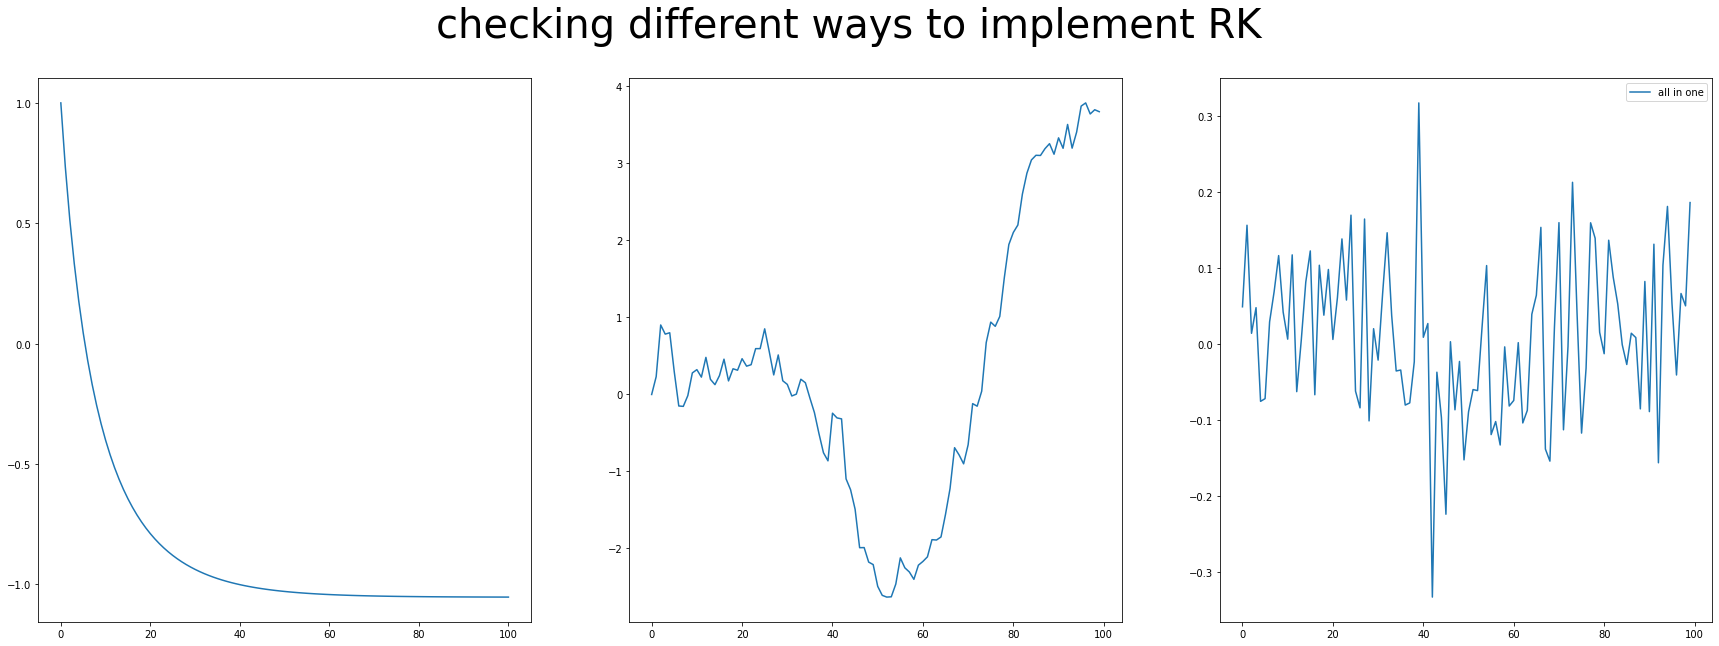

In [15]:
plt.figure(figsize=(30,10))
plt.suptitle("checking different ways to implement RK",size=40)

plt.subplot(131)
plt.plot(np.array(covs)[:,0,0])
#plt.plot(np.array(coovs)[:,0,0],'.', color="red",label="sandwich ricatti")

T = 100
plt.subplot(132)
plt.plot(ss[:,0][:T], label="all in one")
#plt.plot(statees[:,0][:T],'.',color="black",label="sandwich ricatti")

plt.subplot(133)
plt.plot(signals[:,0][:T], label="all in one")
#plt.plot(signaals[:,0][:T],'.',color="black",label="sandwich ricatti")

plt.legend()


Now let's check the Euler using the dy's

In [16]:
from misc import ct
xi = lambda cov,D: np.dot(cov, ct(C)) + ct(D)

ExpA = np.array([[np.cos(omega*dt), -np.sin(omega*dt)], [np.sin(omega*dt), np.cos(omega*dt)]])*np.exp(-gamma*dt/2)

def evolve_simu_state(x, sigma, dy):
    cov = sigma
    XiCov = xi(cov, D)
    dx = np.dot(ExpA-np.eye(2), x) - np.dot(np.dot(XiCov,C), x)*dt + np.dot(XiCov, dy)  #evolution update (according to what you measure)
    dcov = (np.dot(A,cov) + np.dot(cov, ct(A)) + D - np.dot(XiCov, ct(XiCov)))*dt  #covariance update
    return [x + dx, cov + dcov]

sstates = [states[0]]
scovs = [covs[0]]

for ind,dy in enumerate(tqdm(signals)):
    simu = evolve_simu_state(sstates[-1],scovs[-1], dy)
    sstates.append(simu[0])
    scovs.append(simu[1])

100%|██████████| 100/100 [00:00<00:00, 12256.16it/s]


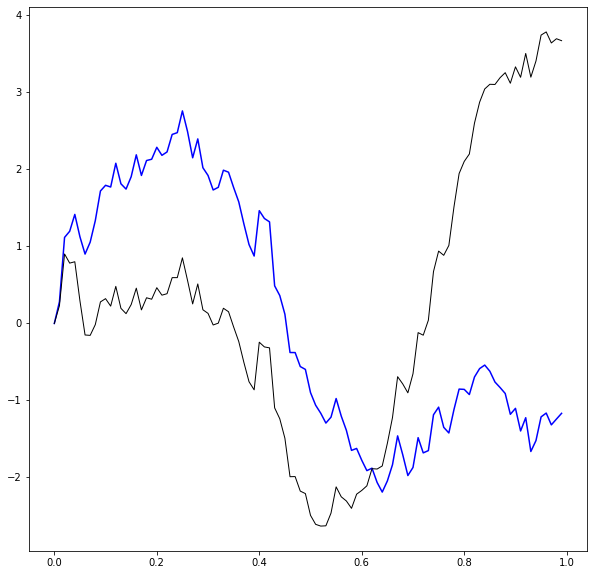

In [17]:
plt.figure(figsize=(10,10))
T=-1
plt.plot(times[:T],np.array(sstates)[:,0][:T], color="blue")
plt.plot(times[:T],states[:,0][:T],color="black", linewidth=1)

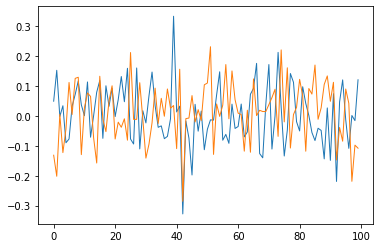

In [19]:
plt.plot(np.array(signals) - np.einsum('ij,bj->bi',C,np.array(states)[:-1])*dt, linewidth=1)

Log likelihood...

In [20]:
np.sum(np.square(np.array(signals) - np.einsum('ij,bj->bi',C,np.array(states)[:-1])*dt))/2

0.9952865808531696

In [21]:
times[-1]

1.0

In [22]:
np.sum(np.square(np.array(signals) - np.einsum('ij,bj->bi',C,np.array(sstates)[:-1])*dt))/2

1.1316989959142467